# CRIPTOATAQUES

In [1]:
import sys
import os

project_root = "/Criptoataques"

if project_root not in sys.path:
    sys.path.append(project_root)

## Análise Estatística dos Textos Originais

Antes de aplicar os algoritmos de criptografia, é fundamental entender as características estatísticas dos textos originais . Essa análise nos fornecerá uma base para comparar o impacto dos algoritmos nas propriedades dos dados.

### Métricas Estatísticas e Comparativos Iniciais

Nesta seção, serão apresentadas e comparadas as análises estatísticas para os textos de diferentes extensões..

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams['text.usetex'] = False

from crypto_io import ler_texto, inteiro_para_texto


from lib.ataques import cifra_de_Cesar as cesar

from lib.ataques.analise_de_frequencia import (
    contar_frequencias,
    frequencia_relativa,
)

from lib.ataques.cifra_de_vigenere.vigenere import VigenereCifra

vigenere = VigenereCifra()
encriptar_decriptar = vigenere.encriptar_decriptar

from lib.ataques.cifra_de_vigenere import ataque as vigenere_ataq

from lib.ataques.rsa_franklin_reiter import (
    ataque_franklin_reiter,
    gerador_caso_relacionado_linear,
)   

from lib.estatisticas import (
    medir_tempo,
    expansao_tamanho,
    calcular_avalanche,
    comparar_algoritmos,
    indice_coincidencia,
    tamanho_bytes,
)



In [17]:

base_path = "examples/textos_base"
arquivos = sorted(f for f in os.listdir(base_path) if f.endswith(".txt"))

textos = {
    os.path.splitext(arquivo)[0].capitalize(): 
    ler_texto(os.path.join(base_path, arquivo))
    for arquivo in arquivos
}

Segue bla bla

In [18]:
def plot_freq(texto, titulo, ax):
    freqs = frequencia_relativa(contar_frequencias(texto))

    letras = list(freqs.keys())
    valores = list(freqs.values())

    ax.bar(letras, valores)
    ax.set_title(titulo)
    ax.set_xlabel("Caracteres")
    ax.set_ylabel("Frequência relativa")
    


def tabela_metricas(textos_dict):
    tabela = {}

    for nome, texto in textos_dict.items():
        freq_abs = contar_frequencias(texto)

        tabela[nome] = {
            "Índice de Coincidência": indice_coincidencia(texto),
            "Total de caracteres": len(texto),
            "Caracteres distintos": len(freq_abs)
        }

    return tabela

Segue uma tabela com as métricas dos textos:

In [19]:
metricas = tabela_metricas(textos)
metricas

{'A_assembleia_dos_ratos_fábula de esopo': {'Índice de Coincidência': 0.043020372441289444,
  'Total de caracteres': 786,
  'Caracteres distintos': 23},
 'A_canção_do_africano(antônio frederico de castro alves)': {'Índice de Coincidência': 0.04357369730280223,
  'Total de caracteres': 1227,
  'Caracteres distintos': 22},
 'A_sobriedade_do_inverno_brasileiro(stephany casali oliveira)': {'Índice de Coincidência': 0.044972544950049424,
  'Total de caracteres': 3778,
  'Caracteres distintos': 24},
 'Cancao_do_exilio': {'Índice de Coincidência': 0.04378346610944234,
  'Total de caracteres': 248,
  'Caracteres distintos': 23},
 'Frankenstein': {'Índice de Coincidência': 0.048061433162221945,
  'Total de caracteres': 490,
  'Caracteres distintos': 24},
 'Lingua_do_p': {'Índice de Coincidência': 0.061329286281212855,
  'Total de caracteres': 3691,
  'Caracteres distintos': 22},
 'Memórias_póstumas_de_brás_cubas (machado de assis)': {'Índice de Coincidência': 0.044988737344983785,
  'Total de c

bla bla bla

Segue os gráficos individuais de frequência:

In [20]:
def plot_freqs_multiplos(textos):
    import math
    
    n = len(textos)
    cols = 2
    rows = math.ceil(n / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axs = axs.flatten()

    for ax, (nome, texto) in zip(axs, textos.items()):
        plot_freq(texto, f"Texto {nome}", ax=ax)

    # Apaga slots vazios
    for ax in axs[len(textos):]:
        ax.remove()

    plt.tight_layout()
    plt.show()



In [5]:
fig, axs = plt.subplots(1, len(textos), figsize=(5 * len(textos), 4))

for ax, (nome, texto) in zip(axs, textos.items()):
    plot_freq(texto, f"Texto {nome}", ax)

plt.tight_layout()
plt.show()

NameError: name 'textos' is not defined

In [21]:
def plot_freqs_linha(textos_dict, titulo="Comparação de Frequências Relativas"):
    plt.figure(figsize=(12, 5))

    # 1) descobre o conjunto completo de caracteres usados
    todas_letras = sorted(
        set().union(*[contar_frequencias(t).keys() for t in textos_dict.values()])
    )

    # 2) plota cada texto como uma linha
    for nome, texto in textos_dict.items():
        freq = frequencia_relativa(contar_frequencias(texto))

        valores = [freq.get(l, 0) for l in todas_letras]

        plt.plot(todas_letras, valores, marker="o", linewidth=1.3, label=nome)

    plt.title(titulo)
    plt.xlabel("Caracteres")
    plt.ylabel("Frequência relativa")

    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


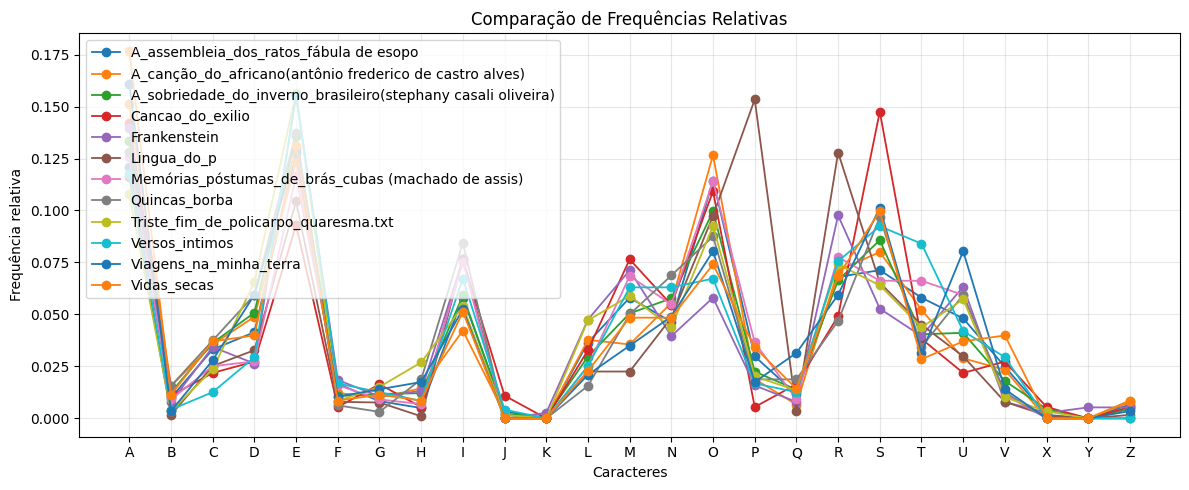

In [22]:
plot_freqs_linha(textos)

bla bla bla

Segue Gráfico comparativo dos três textos

bla bla bla

## Análise de Desempenho dos Algoritmos Criptográficos

Para avaliar a eficácia e segurança dos algoritmos de criptografia, vamos analisar diversas métricas após a aplicação de cada algoritmo aos textos originais. Isso nos permitirá comparar o desempenho e as características dos textos cifrados e decifrados.

### Métricas de Avaliação Detalhadas e Comparativos

#### Tempo de Criptografia/Descriptografia

Esta métrica mede o tempo necessário para um algoritmo criptografar e descriptografar um determinado texto. É crucial para entender a eficiência operacional de cada algoritmo, especialmente em cenários de alta demanda ou com grandes volumes de dados. Um algoritmo mais rápido pode ser preferível, desde que não comprometa a segurança.

*   **Gráficos Comparativos:**

In [23]:
def cesar_cifrar(texto):
    return cesar.cifrar(texto, chave=3)

def cesar_ataque(texto):
    return cesar.ataque_cesar(texto)

def cesar_decifrar(texto):
    return cesar.decifrar(texto,chave=3)



def vigenere_cifrar(texto):
    return encriptar_decriptar(texto, chave="cripto", opcao="cifrar")

def vigenere_ataque(texto):
    return vigenere_ataq.atacar(texto)

def vigenere_decifrar(texto_cifrado):
    return encriptar_decriptar(texto_cifrado, chave="cripto", opcao="decifrar")


# ----------------------------------------
# CONFIGURAÇÕES
# ----------------------------------------
BITS_PARA_TESTE = 2048
MAX_RSA_BYTES = BITS_PARA_TESTE // 8 - 1
E_PARA_TESTE    = 101


# ----------------------------------------
# RSA: CIFRAR
# ----------------------------------------
def rsa_cifrar(texto):
    """
    Gera um caso RSA relacionado (Franklin–Reiter) e devolve c1.
    O caso inteiro é salvo em rsa_cifrar.last_case.
    """

    texto_limitado = texto[:MAX_RSA_BYTES]

    if not texto_limitado:
        raise ValueError("Texto vazio após limitação de tamanho.")

    caso = gerador_caso_relacionado_linear(
        texto1=texto_limitado,
        bits=BITS_PARA_TESTE,
        e_inicial=E_PARA_TESTE
    )

    # Salva o caso para decifrar e atacar depois
    rsa_cifrar.last_case = caso

    # c1 é um inteiro → devolvemos string
    return str(caso["c1"])
    


# ----------------------------------------
# RSA: DECIFRAR
# ----------------------------------------
def rsa_decifrar(texto_cifrado):

    if not hasattr(rsa_cifrar, "last_case"):
        raise RuntimeError("RSA ainda não cifrou nenhum texto.")

    caso = rsa_cifrar.last_case

    c = int(texto_cifrado)
    d = caso["d"]
    n = caso["n"]
    nbytes = caso["nbytes"]

    m = pow(c, d, n)
    return inteiro_para_texto(m, nbytes)



# ----------------------------------------
# RSA: ATAQUE FRANKLIN–REITER
# (usa o MESMO caso do cifrar)
# ----------------------------------------
def ataque_rsa(texto_cifrado):

    if not hasattr(rsa_cifrar, "last_case"):
        raise RuntimeError("RSA ainda não cifrou nenhum texto (nenhum caso disponível).")

    caso = rsa_cifrar.last_case

    return ataque_franklin_reiter(
        caso["c1"],
        caso["c2"],
        caso["e"],
        caso["n"],
        caso["a"],
        caso["b"],
        caso["nbytes"],
        d=caso.get("d"),
    )



algoritmos_combinados = {
    "César": {
        "cifrar": cesar_cifrar,
        "decifrar": cesar_decifrar,
        "atacar": cesar_ataque
    },
     "Vigenere": {
        "cifrar": vigenere_cifrar,
        "decifrar": vigenere_decifrar,
        "atacar": vigenere_ataque
    },
    "RSA": {
        "cifrar": rsa_cifrar,
        "decifrar": rsa_decifrar,
        "atacar": ataque_rsa
    },
}

comparacao = comparar_algoritmos(textos, algoritmos_combinados)

processado:('César', 'A_assembleia_dos_ratos_fábula de esopo')
processado:('César', 'A_canção_do_africano(antônio frederico de castro alves)')
processado:('César', 'A_sobriedade_do_inverno_brasileiro(stephany casali oliveira)')
processado:('César', 'Cancao_do_exilio')
processado:('César', 'Frankenstein')
processado:('César', 'Lingua_do_p')
processado:('César', 'Memórias_póstumas_de_brás_cubas (machado de assis)')
processado:('César', 'Quincas_borba')
processado:('César', 'Triste_fim_de_policarpo_quaresma.txt')
processado:('César', 'Versos_intimos')
processado:('César', 'Viagens_na_minha_terra')
processado:('César', 'Vidas_secas')
processado:('Vigenere', 'A_assembleia_dos_ratos_fábula de esopo')
processado:('Vigenere', 'A_canção_do_africano(antônio frederico de castro alves)')
processado:('Vigenere', 'A_sobriedade_do_inverno_brasileiro(stephany casali oliveira)')
processado:('Vigenere', 'Cancao_do_exilio')
processado:('Vigenere', 'Frankenstein')
processado:('Vigenere', 'Lingua_do_p')
pr

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


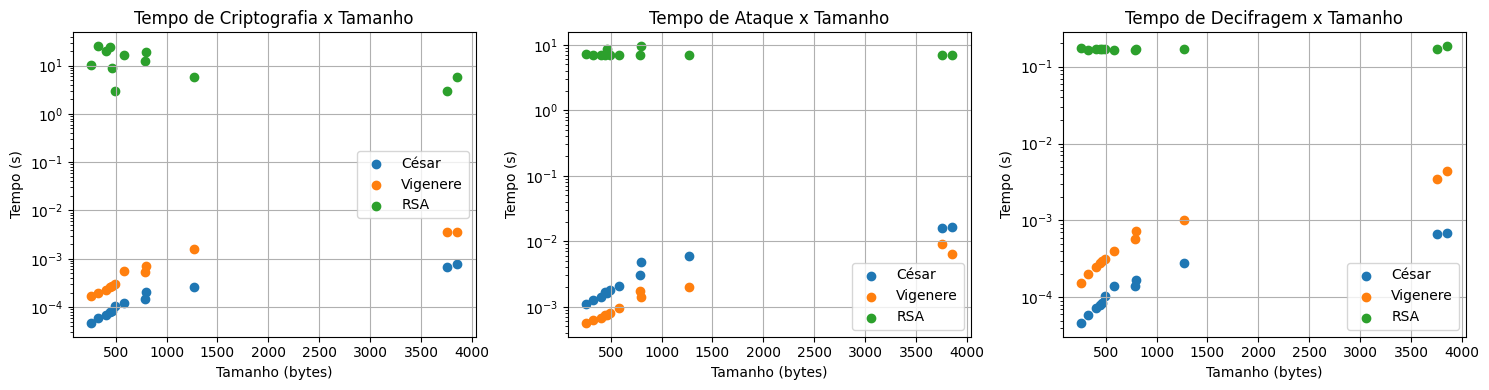

In [24]:
def plot_tempos(comparacao):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    metricas = ["tempo_cifra", "tempo_ataque", "tempo_decifra"]
    titulos = ["Tempo de Criptografia", "Tempo de Ataque", "Tempo de Decifragem"]
    
    for ax, metrica, titulo in zip(axs, metricas, titulos):
        for alg, textos_alg in comparacao.items():
            tamanhos = [dados["tamanho"] for dados in textos_alg.values()]
            tempos   = [dados[metrica]        for dados in textos_alg.values()]
            
            ax.scatter(tamanhos, tempos, marker="o", label=alg)
        
        ax.set_title(f"{titulo} x Tamanho")
        ax.set_xlabel("Tamanho (bytes)")
        ax.set_ylabel("Tempo (s)")
        ax.set_yscale("log")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()
plot_tempos(comparacao)


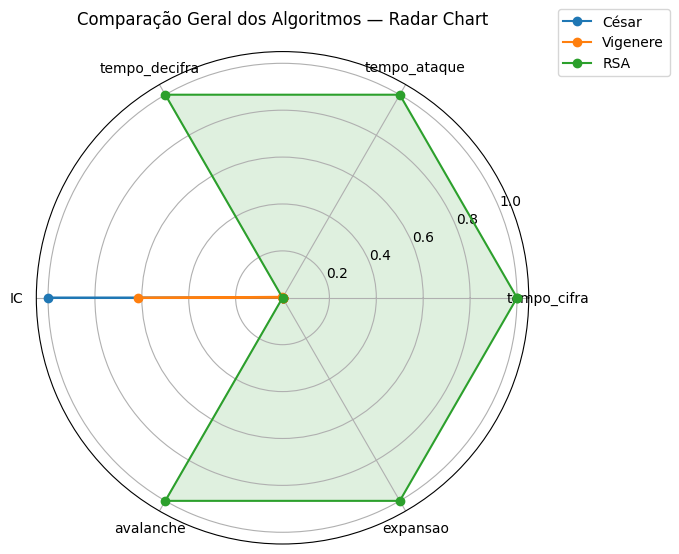

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_radar_algoritmos(comparacao):
    # ------------------------------------------
    # 1) MÉTRICAS QUE VAMOS PLOTAR
    # ------------------------------------------
    metricas = ["tempo_cifra", "tempo_ataque", "tempo_decifra", "IC", "avalanche", "expansao"]
    N = len(metricas)

    # ------------------------------------------
    # 2) AGREGA: média das métricas por algoritmo
    # ------------------------------------------
    medias = {}

    for alg, textos_alg in comparacao.items():
        medias[alg] = []
        for metrica in metricas:
            valores = [dados[metrica] for dados in textos_alg.values()]
            medias[alg].append(np.mean(valores))

    # ------------------------------------------
    # 3) NORMALIZAÇÃO (0–1)
    # ------------------------------------------
    # transforma em matriz
    matriz = np.array(list(medias.values()))
    mins = matriz.min(axis=0)
    maxs = matriz.max(axis=0)
    norm = (matriz - mins) / (maxs - mins + 1e-12)

    # ------------------------------------------
    # 4) PREPARO DO RADAR
    # ------------------------------------------
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))   # fecha o gráfico

    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)

    # ------------------------------------------
    # 5) LINHAS PARA CADA ALGORITMO
    # ------------------------------------------
    for alg, valores_norm in zip(medias.keys(), norm):
        valores_plot = np.concatenate((valores_norm, [valores_norm[0]]))  # fecha o loop
        ax.plot(angles, valores_plot, marker="o", label=alg)
        ax.fill(angles, valores_plot, alpha=0.15)  # “sombreado” bonito

    # ------------------------------------------
    # 6) CONFIGURAÇÃO ESTÉTICA
    # ------------------------------------------
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metricas)
    ax.set_title("Comparação Geral dos Algoritmos — Radar Chart", pad=20)

    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()
plot_radar_algoritmos(comparacao)



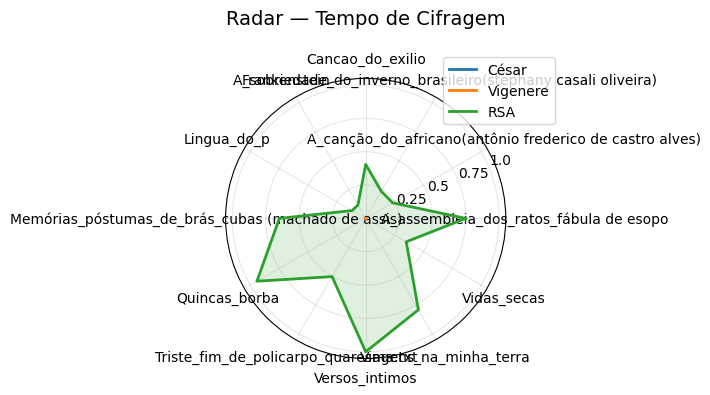

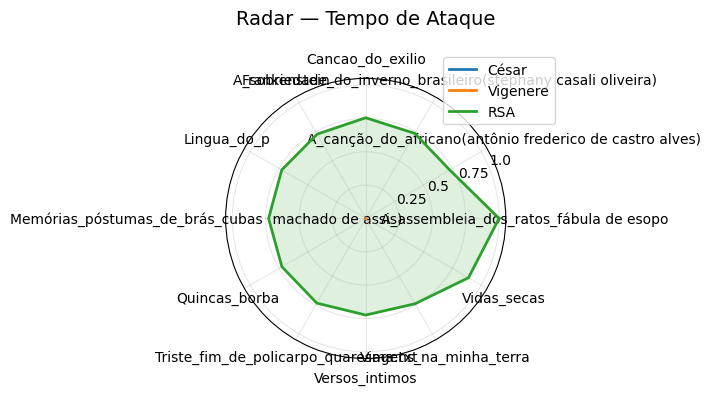

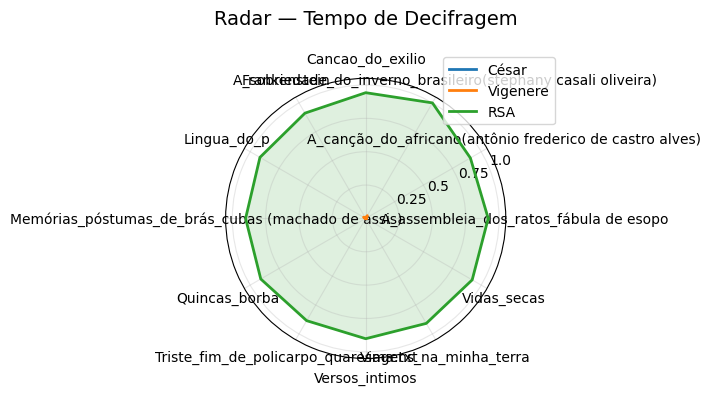

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def radar_metric(comparacao, metrica, titulo):
    textos = list(next(iter(comparacao.values())).keys())
    algs = list(comparacao.keys())

    # matriz de valores: cada linha = algoritmo, colunas = textos
    valores = np.array([
        [comparacao[alg][txt][metrica] for txt in textos]
        for alg in algs
    ], dtype=float)

    # normalização para [0,1] (evita esmagamento)
    max_val = valores.max()
    if max_val > 0:
        valores_norm = valores / max_val
    else:
        valores_norm = valores

    N = len(textos)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]        # fechar o círculo

    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)

    for i, alg in enumerate(algs):
        v = valores_norm[i].tolist()
        v += v[:1]
        ax.plot(angles, v, linewidth=2, label=alg)
        ax.fill(angles, v, alpha=0.15)

    ax.set_title(titulo, fontsize=14, pad=20)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(textos, fontsize=10)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(["0.25", "0.5", "0.75", "1.0"])

    ax.grid(True, alpha=0.3)
    plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.show()


def plot_radar_3_metricas(comparacao):
    radar_metric(comparacao, "tempo_cifra",   "Radar — Tempo de Cifragem")
    radar_metric(comparacao, "tempo_ataque",  "Radar — Tempo de Ataque")
    radar_metric(comparacao, "tempo_decifra", "Radar — Tempo de Decifragem")


# CHAMAR:
plot_radar_3_metricas(comparacao)



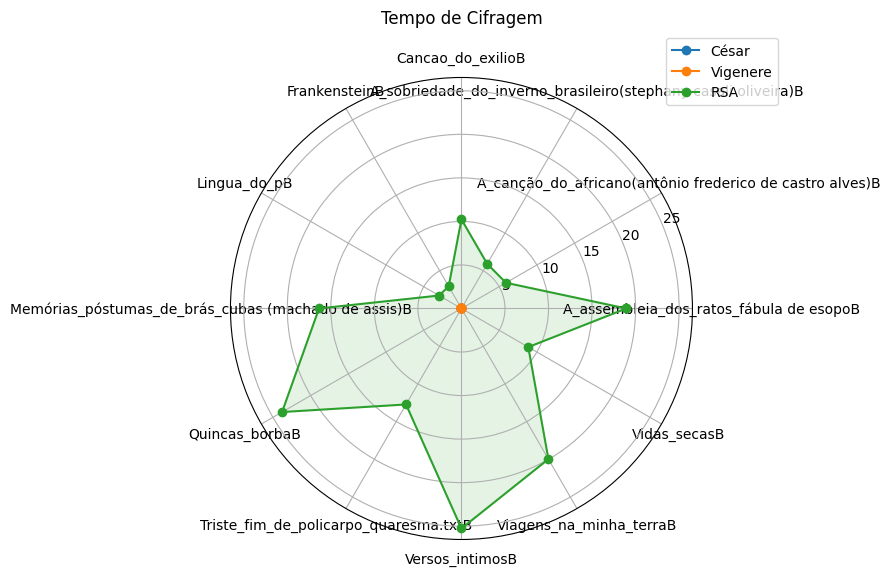

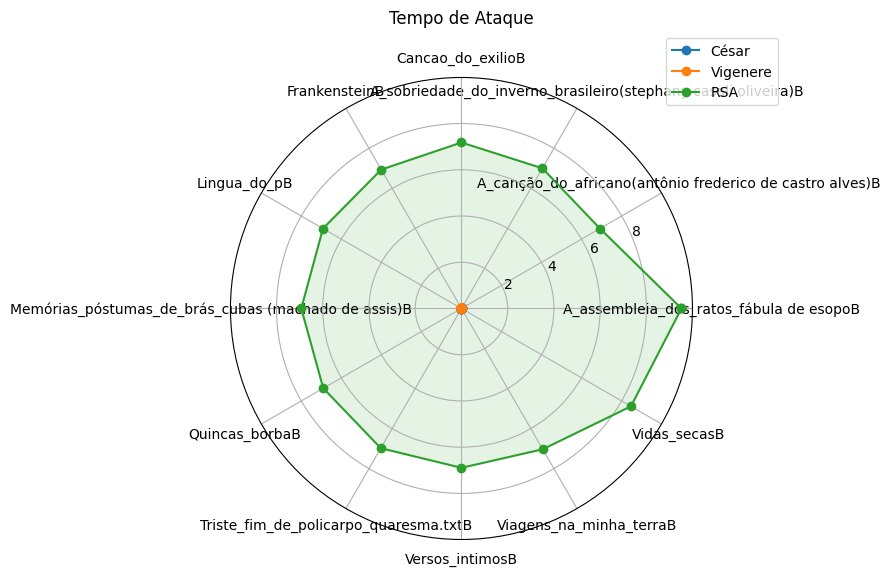

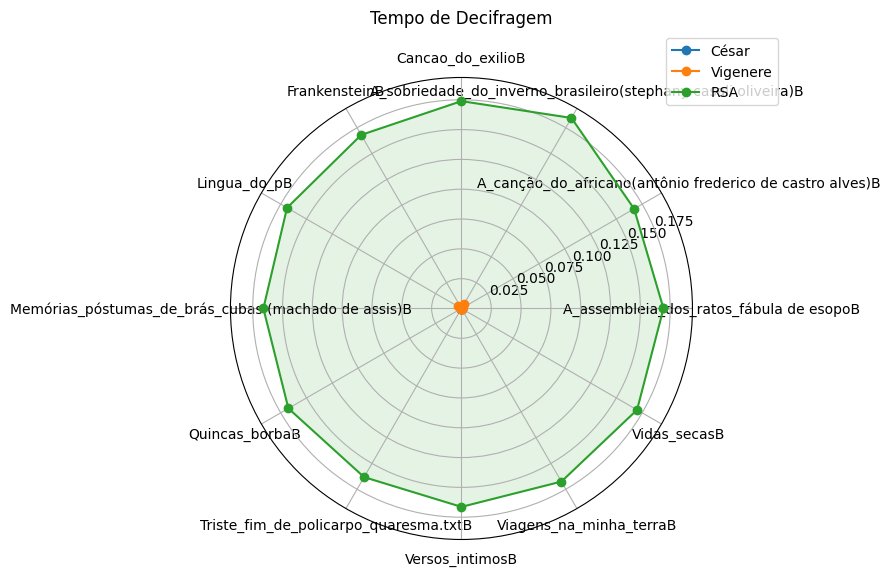

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_radar(comparacao):
    metricas = {
        "tempo_cifra": "Tempo de Cifragem",
        "tempo_ataque": "Tempo de Ataque",
        "tempo_decifra": "Tempo de Decifragem",
    }

    # Para cada métrica, criamos um radar separado
    for metrica, titulo in metricas.items():

        fig = plt.figure(figsize=(6, 6))
        ax = plt.subplot(111, polar=True)

        # ângulos (quantos tamanhos houver)
        # assumindo que todos algoritmos têm os mesmos tamanhos
        tamanhos = list(next(iter(comparacao.values())).keys())
        n = len(tamanhos)

        angulos = np.linspace(0, 2 * np.pi, n, endpoint=False).tolist()
        angulos += angulos[:1]

        # Plotar cada algoritmo com TODOS os valores
        for alg, textos_alg in comparacao.items():
            valores = [textos_alg[t][metrica] for t in tamanhos]
            valores += valores[:1]  # fecha polígono

            ax.plot(angulos, valores, marker='o', label=alg)
            ax.fill(angulos, valores, alpha=0.12)

        # Ajustes estéticos
        ax.set_xticks(angulos[:-1])
        ax.set_xticklabels([f"{t}B" for t in tamanhos])
        ax.set_title(titulo, pad=20)
        ax.grid(True)
        plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
        plt.show()

plot_radar(comparacao)

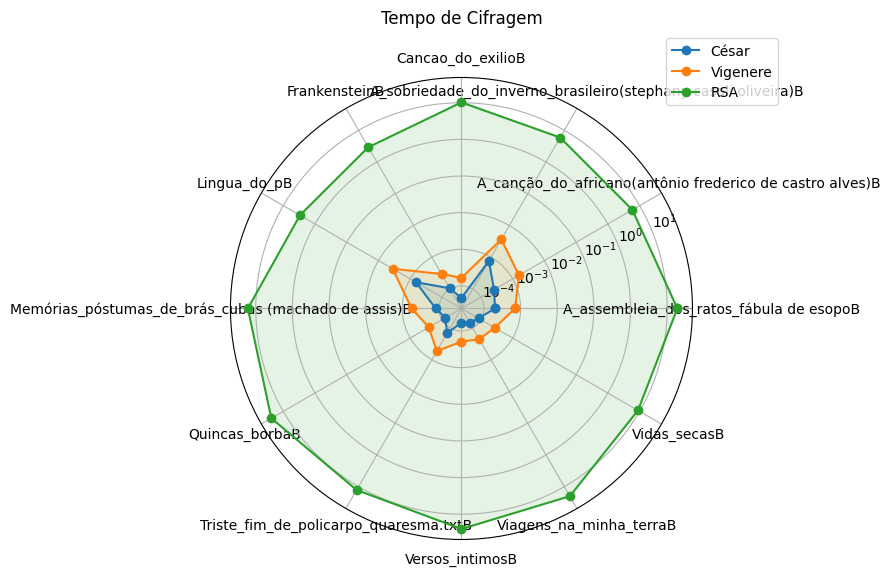

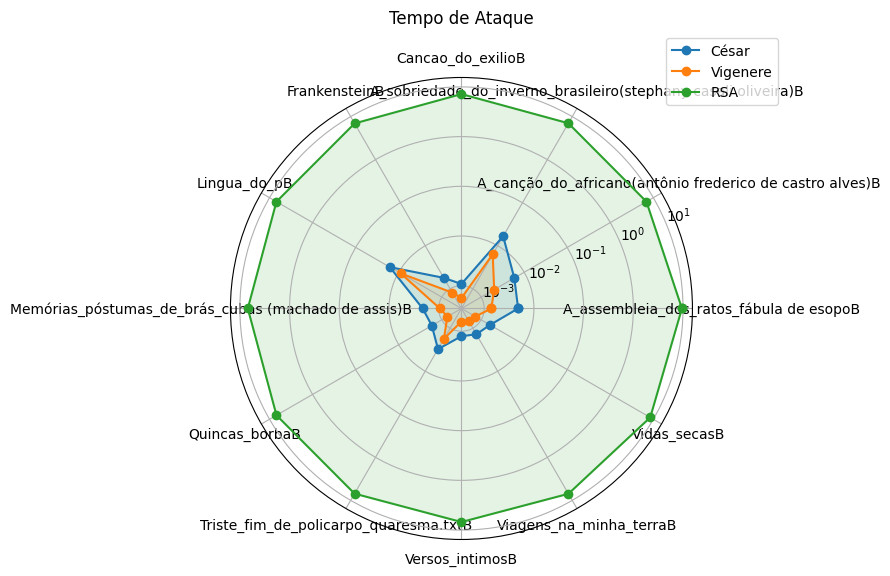

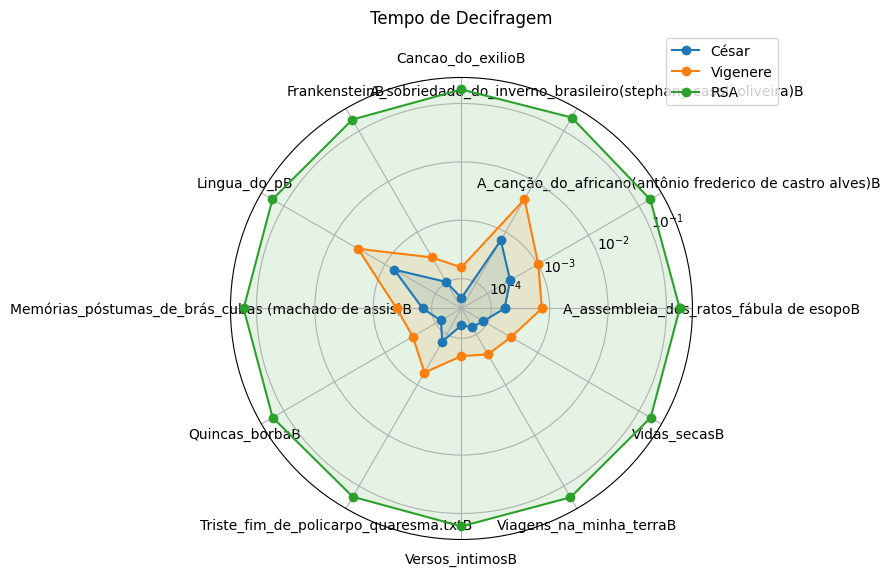

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def plot_radar(comparacao):
    metricas = {
        "tempo_cifra": "Tempo de Cifragem",
        "tempo_ataque": "Tempo de Ataque",
        "tempo_decifra": "Tempo de Decifragem",
    }

    # Para cada métrica, criamos um radar separado
    for metrica, titulo in metricas.items():

        fig = plt.figure(figsize=(6, 6))
        ax = plt.subplot(111, polar=True)

        # ângulos (quantos tamanhos houver)
        tamanhos = list(next(iter(comparacao.values())).keys())
        tamanhos = sorted(tamanhos)  # garantir ordem crescente
        n = len(tamanhos)

        angulos = np.linspace(0, 2 * np.pi, n, endpoint=False).tolist()
        angulos += angulos[:1]

        # Plotar cada algoritmo com TODOS os valores
        for alg, textos_alg in comparacao.items():
            valores = [textos_alg[t][metrica] for t in tamanhos]
            valores += valores[:1]  # fechar polígono

            ax.plot(angulos, valores, marker='o', label=alg)
            ax.fill(angulos, valores, alpha=0.12)

        # Escala logarítmica no eixo radial
        ax.set_rscale("log")

        # Ajustes de rótulos e aparência
        ax.set_xticks(angulos[:-1])
        ax.set_xticklabels([f"{t}B" for t in tamanhos])
        ax.set_title(titulo, pad=20)
        ax.grid(True)
        plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
        plt.show()
plot_radar(comparacao)

*   **Análise Gráfica e de Resultados:**

    [Espaço para a análise textual das observações sobre o tempo de execução, comparando os algoritmos e o impacto do tamanho do texto.]

In [ ]:
def plot_autocorrelacao_e_coocorrencia(dados):
    """
    Recebe o dicionário gerado por gerar_todos_os_plots().
    Gera automaticamente os gráficos.
    """
    for nome_alg, textos in dados.items():
        for nome_txt, info in textos.items():

            auto = info["autocorrelacao"]
            cooc = np.array(info["coocorrencia"])
            cifrado = info["cifrado"]

            fig, axs = plt.subplots(1, 2, figsize=(14, 5))

            # Autocorrelação
            axs[0].plot(auto)
            axs[0].set_title(f"Autocorrelação — {nome_alg} — {nome_txt}")
            axs[0].set_xlabel("Shift")
            axs[0].set_ylabel("Coincidências")

            # Coocorrência
            im = axs[1].imshow(cooc, aspect='auto')
            axs[1].set_title(f"Coocorrência (shift=1) — {nome_alg} — {nome_txt}")
            axs[1].set_xlabel("Letra seguinte")
            axs[1].set_ylabel("Letra atual")

            fig.colorbar(im, ax=axs[1])

            plt.tight_layout()

            plt.show()

#### IC


*   **Teoria:** O Índice de Coincidência é uma ferramenta estatística utilizada para medir a probabilidade de que dois caracteres escolhidos aleatoriamente de um texto sejam iguais. Para textos em linguagem natural, o IC é relativamente alto. Após a criptografia, espera-se que o IC de um texto cifrado seja significativamente menor e próximo ao de um texto aleatório, indicando que a estrutura da linguagem original foi mascarada.

*   **Gráficos Comparativos:**

bla bla

#### Expansão de Tamanho

*   **Teoria:** Esta métrica avalia o quanto o tamanho do texto cifrado se expande em relação ao texto original. Alguns algoritmos criptográficos adicionam bytes extras (por exemplo, devido ao preenchimento - padding) ao texto original, resultando em um texto cifrado maior. A expansão excessiva pode ser um fator a considerar em aplicações com restrições de armazenamento ou largura de banda.

*   **Gráficos Comparativos:**

In [ ]:
def plot_comparativo_expansao(comparacao):
    plt.figure(figsize=(8,5))
    for alg, dados in comparacao.items():
        plt.plot(dados["tamanho"], dados["expansao"], marker="o", label=alg)

    plt.title("Expansão de Tamanho x Tamanho do Texto")
    plt.xlabel("Tamanho (bytes)")
    plt.ylabel("Expansão (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_comparativo_expansao(comparacao)


KeyError: 'tamanho'

<Figure size 800x500 with 0 Axes>

bla bla

#### Efeito Avalanche

*   **Teoria:** O efeito avalanche mede a propriedade de um algoritmo criptográfico onde uma pequena alteração no texto de entrada (ou na chave) resulta em uma grande alteração no texto de saída. Um bom efeito avalanche é essencial para a segurança, pois garante que mesmo pequenas modificações sejam propagadas extensivamente, dificultando a inferência de informações sobre o texto original ou a chave a partir do texto cifrado.

*   **Gráficos Comparativos:**

In [ ]:
def plot_avalanche(pares, label="Avalanche"):
    valores = [calcular_avalanche(orig, mod) for orig, mod in pares]  # (texto, texto_modificado)

    plt.figure(figsize=(8,5))
    plt.plot(range(len(pares)), valores, marker="o")
    plt.xlabel("Amostra")
    plt.ylabel("Diferença (%)")
    plt.title(label)
    plt.grid(True)
    plt.show()

# pares = [(texto, texto_modificado), ...]
# plot_avalanche(pares)

### Visualização: Textos Cifrados e Decifrados

## Cifra de César

## Análise de Frequência


## Cifra de Vigénere

In [ ]:
vigenere = VigenereCifra()

In [ ]:
texto_original = open("examples/cesar_x_vigenere/longo.txt", encoding="utf-8").read()
chave_encr = "cripto"
texto_cifrado = vigenere.encriptar_decriptar(texto_original, chave_encr, "cifrar")
print(texto_cifrado)

C TICVOQ UW PYFKTICH (OPKWCBC HIMSXFKTW SX QCJBGH ONMMH)

EO PR CBBRC JMCSONR,
ATGHCUW CT SUKZTBHC JIAT,
XWEBD TC DIIHXWTF, VD VVCF,
MCMCC F MHVFCMW D LSW TICMC,
G RW RTBVRZ RHFTVU-AAS GD XGTBVF
APNRCUMH WC UVC IHFTRW...

SX IO CISH, IOR VTZFC VARKOXR
WH HZJFA CH TKCPD VFCMI,
FNS VVU CH QQCW P XADRTPK...
S C DMXT JQQ TP KSUGWCWS
CF KPGHQ, V W UBZJZVWH SUTWCWS,
VRTKXN RII CTC Q VARNHCI!

UXGVC KMGKO G CI QXA NFVVX,
RCJ JPGRCJ LT HBFV W HHZ XVU;
TLHC KMGKO G DIXL PQEQIT,
ACJ I DNHTR MJ JIGIW QXA!

Q JWA YOB CI INRQ VU UHUQ,
WIO XA DIIHT HQUI P TFGZI;
CBBILMB LODV KDFC G SMAH
JGI LT MOTUM P IORR-KTBO!

CHCTEOU KMGKOU KID ZFCELTL,
HCF KDFDTZLPL QQDW D FOT,
TWB LICJ XDNQCJ XPEAGZZPL
RCF DDGHCUM SX DGEAPK...

ZC KWSHG XZDTF TGCQOXG,
VFLDL RCEKPF BQ KMGKSKIW;
P ZSPKM AT BCF AT OSPUM
RHAQ RYJB, GQ GWG WWPYMXKC.

Q VARKOXF KPECW R NPEO,
RFZFNS PR CBBRC JIAT
C HFOD XGVRDP T ORROPK;
S C VARKOXR IRTPQL ATN QCEBD,
IFC EID TQQILPK QQD W EKOPKW
D LSW WQAAWPYW P LCPYIG!

H SUTZPOC GEBPH TQZ LTBHCI-AT,

In [ ]:
tamanho_chave = vigenere.tamanho_chave(texto_cifrado)

Tamanhos de chave possíveis (ordenados por frequência):
Tamanho: 6 -- Quantidade: 71
Tamanho: 4 -- Quantidade: 35
Tamanho: 12 -- Quantidade: 32
Tamanho: 9 -- Quantidade: 22
Tamanho: 18 -- Quantidade: 19
Tamanho: 8 -- Quantidade: 17
Tamanho: 5 -- Quantidade: 13
Tamanho: 15 -- Quantidade: 12
Tamanho: 10 -- Quantidade: 11
Tamanho: 7 -- Quantidade: 10
Tamanho: 11 -- Quantidade: 8
Tamanho: 14 -- Quantidade: 8
Tamanho: 16 -- Quantidade: 8
Tamanho: 19 -- Quantidade: 6
Tamanho: 20 -- Quantidade: 6
Tamanho: 13 -- Quantidade: 5
Tamanho: 17 -- Quantidade: 5

Tamanho provável da chave: 6


In [ ]:
chave_encontrada = vigenere.quebra_chave(texto_cifrado,tamanho_chave, 'pt')
print(chave_encontrada)

CRIPTO


In [ ]:
texto_decriptado = vigenere.encriptar_decriptar(texto_cifrado, chave_encontrada,"decifrar")
print(texto_decriptado)

A CANCAO DO AFRICANO (ANTONIO FREDERICO DE CASTRO ALVES)

LA NA UMIDA SENZALA,
SENTADO NA ESTREITA SALA,
JUNTO AO BRASEIRO, NO CHAO,
ENTOA O ESCRAVO O SEU CANTO,
E AO CANTAR CORREM-LHE EM PRANTO
SAUDADES DO SEU TORRAO...

DE UM LADO, UMA NEGRA ESCRAVA
OS OLHOS NO FILHO CRAVA,
QUE TEM NO COLO A EMBALAR...
E A MEIA VOZ LA RESPONDE
AO CANTO, E O FILHINHO ESCONDE,
TALVEZ PRA NAO O ESCUTAR!

MINHA TERRA E LA BEM LONGE,
DAS BANDAS DE ONDE O SOL VEM;
ESTA TERRA E MAIS BONITA,
MAS A OUTRA EU QUERO BEM!

O SOL FAZ LA TUDO EM FOGO,
FAZ EM BRASA TODA A AREIA;
NINGUEM SABE COMO E BELO
VER DE TARDE A PAPA-CEIA!

AQUELAS TERRAS TAO GRANDES,
TAO COMPRIDAS COMO O MAR,
COM SUAS POUCAS PALMEIRAS
DAO VONTADE DE PENSAR...

LA TODOS VIVEM FELIZES,
TODOS DANCAM NO TERREIRO;
A GENTE LA NAO SE VENDE
COMO AQUI, SO POR DINHEIRO.

O ESCRAVO CALOU A FALA,
PORQUE NA UMIDA SALA
O FOGO ESTAVA A APAGAR;
E A ESCRAVA ACABOU SEU CANTO,
PRA NAO ACORDAR COM O PRANTO
O SEU FILHINHO A SONHAR!

O ESCRAVO ENTAO FOI DEITAR-SE,

## Criptografia RSA

In [13]:
# Funções RSA independentes para cada chamada

MAX_RSA_BYTES = 1024
E_PARA_TESTE = 101
BITS_PARA_TESTE = 2048

def rsa_cifrar_independente(texto):
    texto_limitado = texto[:MAX_RSA_BYTES]

    if not texto_limitado:
        raise ValueError("Texto de entrada vazio após limitação de tamanho.")

    # Gera um novo caso RSA para cada cifragem
    caso = gerador_caso_relacionado_linear(
        texto1=texto_limitado,
        bits=BITS_PARA_TESTE,
        e_inicial=E_PARA_TESTE
    )
    # Armazena o caso gerado na própria função para que a decifragem subsequente possa usá-lo
    rsa_cifrar_independente.last_case = caso

    return str(caso["c1"])

def rsa_decifrar_independente(texto_cifrado):

    if not hasattr(rsa_cifrar_independente, 'last_case'):
        raise RuntimeError("Erro: rsa_cifrar_independente não foi chamada. Não há caso RSA para decifrar.")

    caso = rsa_cifrar_independente.last_case

    cifrado = int(texto_cifrado)

    d = caso["d"]
    n = caso["n"]
    nbytes = caso["nbytes"]

    # decifra
    m = pow(cifrado, d, n)

    # converte para texto
    return inteiro_para_texto(m, nbytes)



In [14]:
import pandas as pd
import time

def medir_tempo(func, *args, **kwargs):
    start = time.time()
    resultado = func(*args, **kwargs)
    end = time.time()
    return end - start, resultado


rsa_tempos_ind = {}

for nome, texto in textos.items():
    print(f"Processando texto: {nome}")

    # ----------------------------------------------------------
    # 1) CIFRAGEM NORMAL (sua RSA independente)
    # ----------------------------------------------------------
    tempo_cifra, cifrado = medir_tempo(rsa_cifrar_independente, texto)

    # 2) DECIFRAGEM NORMAL
    tempo_decifra, decifrado = medir_tempo(rsa_decifrar_independente, cifrado)

    # ----------------------------------------------------------
    # 3) ATAQUE FRANKLIN–REITER
    # Gera um caso RELACIONADO ao texto, com (c1, c2, a, b, e, n)
    # ----------------------------------------------------------
    
    caso = gerador_caso_relacionado_linear(texto1=texto, bits=2048, e_inicial=101)

    c1 = caso["c1"]
    c2 = caso["c2"]
    e = caso["e"]
    n = caso["n"]
    a = caso["a"]
    b = caso["b"]
    nbytes = caso.get("nbytes")
    

    tempo_ataque, m1_recuperado = medir_tempo(
        ataque_franklin_reiter,
        c1, c2, e, n, a, b, nbytes, d=caso.get("d")
    )

    # ----------------------------------------------------------
    # 4) ARMAZENAR RESULTADOS
    # ----------------------------------------------------------
    rsa_tempos_ind[nome] = {
        "tamanho_bytes": len(texto.encode('utf-8')),
        "tempo_cifra_s": tempo_cifra,
        "tempo_decifra_s": tempo_decifra,
        "tempo_ataque_s": tempo_ataque
    }

    print(
        f"  Tamanho: {len(texto.encode('utf-8'))} bytes, "
        f"Cifra: {tempo_cifra:.6f}s, "
        f"Decifra: {tempo_decifra:.6f}s, "
        f"Ataque: {tempo_ataque:.6f}s"
    )


rsa_tempos_ind_df = pd.DataFrame.from_dict(rsa_tempos_ind, orient='index')
rsa_tempos_ind_df.index.name = 'Texto'
display(rsa_tempos_ind_df)



Processando texto: Cancao_do_exilio
  Tamanho: 259 bytes, Cifra: 16.164050s, Decifra: 0.165468s, Ataque: 6.896321s
Processando texto: Quincas_borba
  Tamanho: 449 bytes, Cifra: 10.161829s, Decifra: 0.166660s, Ataque: 7.172187s
Processando texto: Triste_fim_de_policarpo_quaresma.txt


ValueError: Texto codificado não cabe em n.

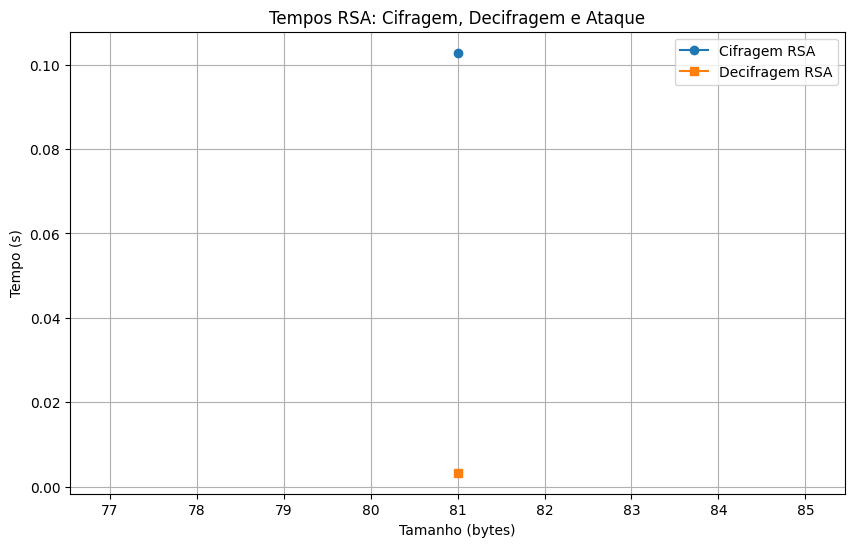

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

tamanhos = rsa_tempos_ind_df["tamanho_bytes"]
tempos_cifra = rsa_tempos_ind_df["tempo_cifra_s"]
tempos_decifra = rsa_tempos_ind_df["tempo_decifra_s"]
tempos_ataque = rsa_tempos_ind_df["tempo_ataque_s"]

plt.plot(tamanhos, tempos_cifra, marker='o', label="Cifragem RSA")
plt.plot(tamanhos, tempos_decifra, marker='s', label="Decifragem RSA")
plt.plot(tamanhos, tempos_ataque, marker='^', label="Ataque Franklin-Reiter")

plt.title("Tempos RSA: Cifragem, Decifragem e Ataque")
plt.xlabel("Tamanho (bytes)")
plt.ylabel("Tempo (s)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
ic_rsa_ind_results = {}
for nome_texto, texto_original in textos.items():
    # Cifrar de forma independente para cada texto
    cifrado_independente = rsa_cifrar_independente(texto_original)
    ic_rsa_ind_results[nome_texto] = indice_coincidencia(cifrado_independente)

print("Índice de Coincidência dos textos cifrados por RSA (Independente):")
for texto, ic_val in ic_rsa_ind_results.items():
    print(f"  {texto}: {ic_val:.4f}")

ic_df_ind = pd.DataFrame(ic_rsa_ind_results.items(), columns=['Texto', 'IC Cifrado (RSA Independente)'])
display(ic_df_ind)

Índice de Coincidência dos textos cifrados por RSA (Independente):
  Curto1: 0.0000


,Texto,IC Cifrado (RSA Independente)
0,Curto1,0.0


In [ ]:
expansao_rsa_ind_results = {}
for nome_texto, texto_original in textos.items():
    # Cifrar de forma independente para cada texto
    cifrado_independente = rsa_cifrar_independente(texto_original)
    original_size = len(texto_original.encode('utf-8'))
    ciphered_size = len(cifrado_independente)

    expansao_rsa_ind_results[nome_texto] = expansao_tamanho(original_size, ciphered_size)



print("Expansão de Tamanho dos textos cifrados por RSA (Independente):")
for texto, expansao_val in expansao_rsa_ind_results.items():
    print(f"  {texto}: {expansao_val:.2f}%")

expansao_df_ind = pd.DataFrame(expansao_rsa_ind_results.items(), columns=['Texto', 'Expansão (%) (RSA Independente)'])
display(expansao_df_ind)

Aviso: O expoente e=7 não é coprimo de phi. Gerando um novo...
Expansão de Tamanho dos textos cifrados por RSA (Independente):
  Curto1: 3.81%


,Texto,Expansão (%) (RSA Independente)
0,Curto1,3.814815


In [ ]:
from typing import Callable


def bytes_from_output(out) -> bytes:
    """Converte qualquer saída comum de cifradores em bytes."""
    if isinstance(out, bytes):
        return out
    if isinstance(out, str):
        return out.encode('utf-8')
    if isinstance(out, int):
        length = (out.bit_length() + 7) // 8
        return out.to_bytes(length, 'big')
    if isinstance(out, list):
        return bytes(out)
    raise TypeError("Tipo de saída não suportado para cálculo de avalanche.")


def calcular_avalanche(func_encrypt: Callable, texto: str) -> float:
    """
    Mede avalanche com base na diferença de bits entre:
    - texto original
    - texto com 1 caractere alterado
    Retorna porcentagem de bits diferentes.
    """
    if len(texto) == 0:
        return 0.0

    # cifra original
    out1 = bytes_from_output(func_encrypt(texto))

    # cifra do texto alterado
    alterado = chr((ord(texto[0]) + 1) % 256) + texto[1:]
    out2 = bytes_from_output(func_encrypt(alterado))

    # iguala comprimentos com 0x00
    max_len = max(len(out1), len(out2))
    out1 = out1.ljust(max_len, b"\x00")
    out2 = out2.ljust(max_len, b"\x00")

    # conta bits diferentes
    dif_bits = 0
    total_bits = max_len * 8

    for b1, b2 in zip(out1, out2):
        dif_bits += bin(b1 ^ b2).count("1")

    return dif_bits / total_bits


In [12]:
# Recarrega módulos e roda o diagnóstico
import importlib
from lib.ataques.rsa_franklin_reiter import gerador_caso_relacionado_linear, ataque_franklin_reiter
import lib.ataques.rsa_franklin_reiter.ataque as ataque_mod
import lib.ataques.rsa_franklin_reiter.mensagens_relacionadas as msg_mod
import crypto_io.util_io as util_io

importlib.reload(ataque_mod)
importlib.reload(msg_mod)
importlib.reload(util_io)

# Diagnóstico
texto_teste = "Canção do Exílio (Gonçalves Dias) Minha terra tem palmeiras, Onde canta o Sabiá; As aves que aqui gorjeiam,  Não gorjeiam como lá. Nosso céu tem mais estrelas, Nossas várzeas têm mais flores, Nossos bosques têm mais vida, Nossa vida mais amores."
caso = gerador_caso_relacionado_linear(texto1=texto_teste, bits=1024, e_inicial=7)
c1, c2, e, n, a, b = caso["c1"], caso["c2"], caso["e"], caso["n"], caso["a"], caso["b"]
nbytes = caso.get("nbytes")
print("Tipos iniciais:")
print("  type(c1)=", type(c1))
print("  type(c2)=", type(c2))
print("  type(e)=", type(e))
print("  type(n)=", type(n))
print("  type(a)=", type(a))
print("  type(b)=", type(b))
print("  type(nbytes)=", type(nbytes), "value=", nbytes)

res = ataque_franklin_reiter(c1, c2, e, n, a, b, nbytes, d=caso.get("d"))
print("Retorno ataque:", type(res), repr(res))

if isinstance(res, tuple):
    m1 = res[0]
else:
    m1 = res

print("m1 tipo:", type(m1))
try:
    m1_int = int(m1)
    print("m1 convertido para int com sucesso; bit_length=", m1_int.bit_length())
except Exception as ex:
    print("Falha ao converter m1 para int:", ex)

# Tentativa de conversão segura para texto (se nbytes informado)
try:
    tamanho = nbytes if isinstance(nbytes, int) and nbytes>0 else max(1, (m1_int.bit_length() + 7)//8)
    print("tamanho usado para conversão:", tamanho)
    texto = util_io.inteiro_para_texto(m1_int, tamanho)
    print("texto recuperado:", texto)
except Exception as ex:
    print("Erro durante inteiro->texto:", ex)

Tipos iniciais:
  type(c1)= <class 'int'>
  type(c2)= <class 'int'>
  type(e)= <class 'int'>
  type(n)= <class 'int'>
  type(a)= <class 'int'>
  type(b)= <class 'int'>
  type(nbytes)= <class 'int'> value= 256
Retorno ataque: <class 'tuple'> (8506012274457221134085255180005754533097926032233711169679483944249576371020380814643855901013808723121285951719862671368679971842484707104597225765465683882860158157310687739069600134207179932060532069009875654181409322148140961310462469752910969706951053980926140120628013124584135139146329072183940685377909572419541292061617465151929890896902001159369517946516236450949246930804867692314231530970330451973992347364550364363119697179948874443101600315494393627400108804464284410430664918270302411448817517373370491104589252498293141153815341002786114692496564500871710393036284780855075301198856804799473934234414, 'Canção do Exílio (Gonçalves Dias) Minha terra tem palmeiras, Onde canta o Sabiá; As aves que aqui gorjeiam,  Não gorjeiam como lá. Nosso cé